### Plan
1. Prepare the data: For each document, split it into chunks of appropriate size (e.g., paragraphs or a fixed number of sentences). Pair each chunk with the question attached to the document, creating a dataset of question-chunk pairs.

2. Input preparation: Tokenize the questions and chunks, and create input sequences by concatenating the tokenized question and chunk, separated by a special separator token like [SEP]. The input sequence will look like this: [CLS] question_tokens [SEP] chunk_tokens [SEP]. Also, create attention masks to indicate the positions of tokens in the input sequences.

3. Model configuration: Select a pre-trained BERT model and configure it for a masked language modeling (MLM) task. In this task, the model learns to predict masked tokens in the input sequence based on the context provided by the remaining tokens.

4. Data masking: For each input sequence, mask a certain percentage of the question tokens (e.g., 15%). The goal is to make the model learn to reconstruct the original question using the context provided by the chunk.

5. Fine-tuning: Train the BERT model on your training dataset using a suitable optimizer, learning rate scheduler, and loss function. For the MLM task, you can use the cross-entropy loss between the predicted tokens and the original tokens. Monitor the model's performance on a validation set to avoid overfitting and select the best model checkpoint based on the validation metrics.

In [1]:
import glob
import os
import re
import pandas as pd
import numpy as np

In [2]:
#First I get all the ids of the rephrase questions
ids = [int(file.split('\\')[-1].split('.')[0]) for file in glob.glob('../data/questions_rephrased/*.txt')]

In [3]:
len(ids)

61176

In [4]:
Random_subset = pd.read_pickle('../data/raw/random_subset.pkl')
Dokument = pd.read_pickle('../data/raw/Dokument.pkl')
Sag = pd.read_pickle('../data/raw/Sag.pkl')
Fil = pd.read_pickle('../data/raw/Fil.pkl')


In [5]:
Subset_dokument = Dokument[Dokument['id'].isin(ids)]
len(Subset_dokument)

61176

In [6]:
#Identifying the files that are linked to the rephrased questions
Subset_fil = Fil[Fil['dokumentid'].isin(Subset_dokument['id'])]
len(Subset_fil)

75164

In [7]:
#Creating dict that maps the fil ids to their corresponding rephrased question ids
fil_to_question = {}
for index, row in Subset_fil.iterrows():
    #check if the fil id is already in the dict
    if row['id'] in fil_to_question:
        #if it is, append the question id to the list
        fil_to_question[row['id']].append(row['dokumentid'])
    else:
        #if it is not, create a new list with the question id
        fil_to_question[row['id']] = [row['dokumentid']]
        

In [8]:
len(fil_to_question)

75164

In [9]:
# Initialize the question_to_fil dictionary with all dokumentid values
question_to_fil = {dok_id: [] for dok_id in Subset_dokument['id']}

# Update the question_to_fil dictionary with the corresponding fil IDs
for key, value in fil_to_question.items():
    for v in value:
        question_to_fil[v].append(key)

len(question_to_fil)


61176

In [10]:
#removing all the questions that are not linked to any files
question_to_fil_filtered = {key: value for key, value in question_to_fil.items() if value != []}
len(question_to_fil_filtered)

55300

In [11]:
import pickle

In [12]:
with open('../data/raw/question_to_fil_filtered.pkl', 'wb') as handle:
    pickle.dump(question_to_fil_filtered, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
#save the dict as pickle 
import pickle
with open('../data/raw/question_to_fil.pkl', 'wb') as handle:
    pickle.dump(question_to_fil, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
len(question_to_fil)

61176

In [15]:
len(set(question_to_fil.keys()))

61176

In [16]:
#Now I can load the txt files that contain the files related to the rephrased questions

#loading the txt files for the first 10 files related to the rephrased questions

files = []
basename = []
for i in range(10):
    txt = [question_to_fil[ids[i]]]
    for t in txt:
        basename.append(t)

    for name in basename:
        try:
            with open('../data/processed/' + str(name) + '.txt', 'r') as f:
                files.append(f.read())  
        except:
            print(f'File {name} not found')

File [1768106] not found
File [1768106] not found
File [1768133] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File [1768144] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File [1768144] not found
File [1768154] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File [1768144] not found
File [1768154] not found
File [195443, 195544] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File [1768144] not found
File [1768154] not found
File [195443, 195544] not found
File [1768266] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File [1768144] not found
File [1768154] not found
File [195443, 195544] not found
File [1768266] not found
File [1768290] not found
File [1768106] not found
File [1768133] not found
File [1768136] not found
File

In [17]:
len(Subset_fil)

75164

In [18]:
#getting the rephrased question
question_basenames = fil_to_question[basename[0]]

with open('../data/questions_rephrased/' + str(question_basenames) + '.txt', 'r', encoding='iso-8859-1') as f:
    question = f.read()
print(f"The rephrased question is: {question}")

TypeError: unhashable type: 'list'

In [19]:
from sentence_transformers import SentenceTransformer
# Calculate similarities between sentences
from sklearn.metrics.pairwise import cosine_similarity
# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt
# package for finding local minimas
from scipy.signal import argrelextrema
import math
import re

In [20]:
print(files[0])
doc = files[0]

IndexError: list index out of range

In [27]:
with open('../data/processed/1832103.txt', 'r') as f:
    doc = f.read()

In [28]:
#replace \n with space
doc = re.sub(r'\n', ' ', doc)

In [32]:
sentences = re.split('[?.]', doc)
len(sentences)

332

In [34]:
start = 0
end = len(sentences) - 1
while start <= end:
    if len(sentences[start]) < 30:
        try:
            sentences[start] = sentences[start] + sentences[start + 1]
            sentences.pop(start + 1)
            end -= 1
        except:
            start += 1
    else:
        start += 1


### Unify sentence length

In [35]:
len(sentences)

269

In [36]:
# Get the length of each sentence
sentece_length = [len(each) for each in sentences]
# Determine longest outlier
long = np.mean(sentece_length) + np.std(sentece_length) *2
# Determine shortest outlier
short = np.mean(sentece_length) - np.std(sentece_length) *2
# Shorten long sentences
text = ''
for each in sentences:
    if len(each) > long:
        # let's replace all the commas with dots
        comma_splitted = each.replace(',', '.')
    else:
        text+= f'{each}. '
sentences = text.split('. ')
# Now let's concatenate short ones
text = ''
for each in sentences:
    if len(each) < short:
        text+= f'{each} '
    else:
        text+= f'{each}. '

In [37]:
len(sentences)

259

In [44]:
from danlp.models import load_bert_base_model
import torch
model = load_bert_base_model()


Some weights of the model checkpoint at C:\Users\rune7\.danlp\bert.botxo.pytorch were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
embeddings = []
for sentence in sentences:
    _, sentence_embedding, _ = model.embed_text(sentence)
    embeddings.append(sentence_embedding.numpy().flatten())

embeddings = np.vstack(embeddings)


In [46]:
print(embeddings.shape)

(259, 768)


In [47]:
# Create similarities matrix
similarities = cosine_similarity(embeddings)


Text(0.5, 1.0, 'Cosine similarities matrix')

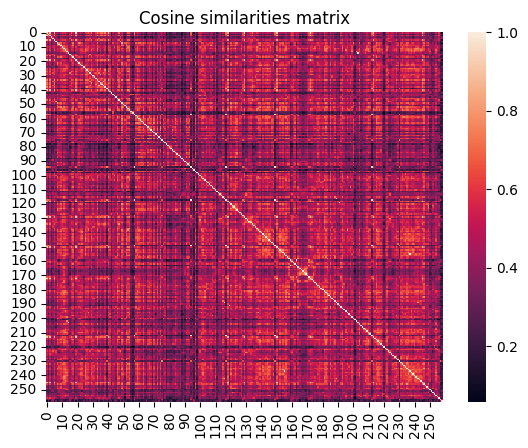

In [48]:
# Lets plot the result we got
sns.heatmap(similarities).set_title('Cosine similarities matrix')

# Find splitting points


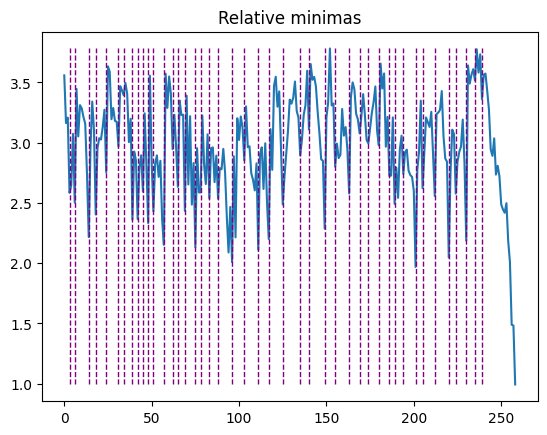

In [49]:
def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))
    
def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        p_size = min(p_size, similarities.shape[0])
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=10)

# Let's create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas')
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full args')

In [166]:
# Create empty string
split_points = [each for each in minmimas[0]]
text = ''
for num,each in enumerate(sentences):
    if num in split_points:
        text+=f'\n\n {each}. '
    else:
        text+=f'{each}. '

In [167]:
print(text)

  GRU, Almdel - 2020-21 - Endeligt svar på spørgsmål 124: Spm.  om, hvorvidt det stadig er forventningen, at der tilbydes behandling til voksne personer med seksuelt krænkende adfærd mod børn og unge under 18 år, til socialministeren  Grønlandsudvalget 2020-21GRU Alm. del Offentligt  Folketingets Grønlandsudvalg Holmens Kanal 22 1060 København K Telefon 33 92 93 00 sm@sm. 

 dk wwwsmdk Sagsnr 2021 - 6590 Doknr.  468952 Dato 08-10-2021 Folketingets Grønlandsudvalg har d.  20 september 2021 stillet følgende spørgsmål nr.  124 (alm del) til social- og ældreministeren, som hermed besvares.  Spørgsmålet er stillet efter ønske fra Aaja Chemnitz Larsen (IA). 

  Der henvises til svar på GRU alm.  del - spm 52” Svar: Spørgsmålet referer til tidligere besvarelse af GRU alm.  del – spm 52, om det grønlandsk-tværgående arbejde for en styrket indsats for børn og unge i Grønland.  I denne indsats indgår en række initiativer, hvoraf en række af dem er et samarbejde mellem Grønland og Danmark og en r

# I made the src/data/extract_paragraphs.py script to do this

In [139]:
    
def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum 
        Returns:
            list: list of weighted sums
        """
        p_size = min(p_size, similarities.shape[0])

        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid) 
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

In [39]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from danlp.models import load_bert_base_model

def split_into_paragraphs(text, max_tokens=500):
    # Replace \n with space
    text = re.sub(r'\n', ' ', text)

    # Split the text into sentences based on '?' and '.'
    sentences = re.split('[?.]', text)

    # Concatenate short sentences
    start = 0
    end = len(sentences) - 1
    while start <= end:
        if len(sentences[start]) < 30:
            sentences[start] = sentences[start] + sentences[start + 1]
            sentences.pop(start + 1)
            end -= 1
        else:
            start += 1

    # Concatenate long sentences
    text = ''
    for each in sentences:
        if len(each) > 500:
            comma_splitted = each.replace(',', '.')
        else:
            text += f'{each}. '
    sentences = text.split('. ')
    text = ''
    for each in sentences:
        if len(each) < 30:
            text += f'{each} '
        else:
            text += f'{each}. '

    # Calculate sentence embeddings
    model = load_bert_base_model()
    embeddings = []
    for sentence in sentences:
        _, sentence_embedding, tokenized_text = model.embed_text(sentence)
        embeddings.append(sentence_embedding.numpy().flatten())
    embeddings = np.vstack(embeddings)

    # Calculate cosine similarities between sentences
    similarities = np.matmul(embeddings, embeddings.T)

    # Find relative minima of activated similarities
    activated_similarities = activate_similarities(similarities, p_size=10)
    minmimas = argrelextrema(activated_similarities, np.less, order=2)

    # Split the text into paragraphs based on the relative minima
    paragraphs = []
    current_paragraph = ''
    for i, sentence in enumerate(sentences):
        current_paragraph += sentence + ' '
        if i in minmimas[0]:
            paragraphs.append(current_paragraph)
            current_paragraph = ''

    return paragraphs

# Load the text file
with open('../data/processed/1626812.txt', 'r') as f:
    text = f.read()
# Split the text into paragraphs
paragraphs = split_into_paragraphs(text)

for p in paragraphs:
    print(p)
    print('----------------')


Some weights of the model checkpoint at C:\Users\rune7\.danlp\bert.botxo.pytorch were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'activate_similarities' is not defined